# Calculate the Lesion Damage Score for a set of lesion against a statistical map

### Authors: Alexander Cohen, Michael Ferguson

Use this to calculate **Network Damage Scores (NDS)** for a set of lesions against a particular statistical map and calculate the correlation and P-value against a particular independent variable

Notes:
- You will need a csv file that provides the paths to your lesions, usually created from the [Preprocessing](https://github.com/nimlab/templates/blob/master/py3_notebooks/1_Preprocessing_LesionQA_fcGen_XNATupload.ipynb) or [xnat_grabber](https://github.com/nimlab/templates/blob/master/xnat_grabber.ipynb) notebooks.
- Add the behavioral variable of interest as an additional column in your csv file


In [1]:
## Packages and environmental settings:

##Packages:
import os
import sys
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm

from matplotlib import pyplot as plt
from nilearn import image, input_data

from nimlab import software as sf

%matplotlib inline

### 1. Provide your email address for future reference:

In [ ]:
# Enter your email address here in quotes:
creator_email = "alexander.cohen2@childrens.harvard.edu"

### 2. Where are your data? and where do you want the results to go?
NOTES: 
- `dataset_csv` is the csv file created from the `Preprocessing` or `xnat_grabber` notebooks that points to your Lesions and fcMaps (will also work with older csv files from `xnat_gate`).
- If you are examining multiple datasets, your csv should contain both, i.e., specify both in xnat_grabber, or just concatenate the files in excel, etc...

In [2]:
# Specify the path to your dataset.csv file

# dataset_csv = "your_dataset_csv_file.csv"
# output_dir = "3_PALM_Analysis_of_datasetA_and_covariateB"

dataset_csv = "hospital_ds.csv"
target_network_file = "vlsm.nii"
output_dir = "template_palm"
VOI = 'nihss_hospital'

clean_df = pd.read_csv(dataset_csv)

### Code to remove rows where a particular column has no data:
clean_df.dropna(how='any', subset=[VOI],inplace=True)
### Code to remove rows where a particular column has no data:

### Code for LOOCV computation
# Set LOOCV to True and run the notebook as an ipython script with a single argument
# (which row to drop, starts from 1 for the non-pythonic user)
LOOCV = False
if LOOCV:
    keepnumber=int(sys.argv[1])-1
    LOO_subject=clean_df.loc[keepnumber,'subject']
    LOO_lesion=clean_df.loc[keepnumber,'lesion']
    print("I am only going to calculate the NDS for person #",sys.argv[1],"which was:",LOO_subject)
    clean_df=clean_df.loc[keepnumber,:]
    #clean_df.keep() drop(dropnumber,inplace=True)
    output_dir = output_dir + "_" + sys.argv[1]
    print("Output will now be saved in",output_dir)
### Code for LOOCV computation

input_imgs = clean_df['lesion']

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not LOOCV: print("I found", len(clean_df), "participants in", len(clean_df.dataset.unique()),"different datasets:",clean_df.dataset.unique())
print("")
print("Results will be stored in a sub-directory named: ",output_dir)
display(clean_df)

I found 119 participants in 1 different datasets: ['corbetta_stroke']

Results will be stored in a sub-directory named:  template_palm


,dataset,subject,lesion,nihss_hospital,Intercept
0,corbetta_stroke,FCS_024,brain_lesions/FCS_024_A_lesion_ifhfix.nii,23,1
1,corbetta_stroke,FCS_026,brain_lesions/FCS_026_A_lesion_ifhfix.nii,2,1
2,corbetta_stroke,FCS_027,brain_lesions/FCS_027_A_lesion_ifhfix.nii,20,1
3,corbetta_stroke,FCS_029,brain_lesions/FCS_029_A_lesion_ifhfix.nii,2,1
4,corbetta_stroke,FCS_030,brain_lesions/FCS_030_A_lesion_ifhfix.nii,10,1
...,...,...,...,...,...
114,corbetta_stroke,FCS_181,brain_lesions/FCS_181_A_lesion_ifhfix.nii,12,1
115,corbetta_stroke,FCS_182,brain_lesions/FCS_182_A_lesion_ifhfix.nii,3,1
116,corbetta_stroke,FCS_183,brain_lesions/FCS_183_A_lesion_ifhfix.nii,2,1
117,corbetta_stroke,FCS_184,brain_lesions/FCS_184_A_lesion.nii,0,1


### 3. Calculate Damage Score for each Lesion:

In [6]:
target_network = image.load_img(target_network_file)
NDS_all=[]
NDS_pos_only=[]
NDS_neg_only=[]

NDS_all_avg=[]
NDS_pos_only_avg=[]
NDS_neg_only_avg=[]

if LOOCV:
    input_imgs = [input_imgs]

for lesion in tqdm(input_imgs):
    # Define a 3D->1D masker object from the lesion (the zero smooth thing is to remove NaNs):
    masker = input_data.NiftiMasker(image.smooth_img(lesion, fwhm=None), standardize=False)

    # Obtain the values in the target network map within the lesion:
    target_values_in_lesion = masker.fit_transform(target_network)

    # Calculate the sum of the values, using all, just positive, and just negative values:
    NDS_all.append(np.nan_to_num(np.sum(np.nan_to_num(target_values_in_lesion))))
    NDS_pos_only.append(np.nan_to_num(np.sum(np.nan_to_num(target_values_in_lesion[target_values_in_lesion>0]))))
    NDS_neg_only.append(np.nan_to_num(np.sum(np.nan_to_num(target_values_in_lesion[target_values_in_lesion<0]))))

    # Calculate the avg of the values, using all, just positive, and just negative values (if ALL pos or ALL neg, score=0 for the other):
    NDS_all_avg.append(np.nan_to_num(np.mean(np.nan_to_num(target_values_in_lesion), dtype=np.float64)))
    NDS_pos_only_avg.append(np.nan_to_num(np.mean(np.nan_to_num(target_values_in_lesion[target_values_in_lesion>0]), dtype=np.float64)))
    NDS_neg_only_avg.append(np.nan_to_num(np.mean(np.nan_to_num(target_values_in_lesion[target_values_in_lesion<0]), dtype=np.float64)))


clean_df['NDS_all']=NDS_all
clean_df['NDS_pos']=NDS_pos_only
clean_df['NDS_neg']=NDS_neg_only

clean_df['NDS_all_avg']=NDS_all_avg
clean_df['NDS_pos_avg']=NDS_pos_only_avg
clean_df['NDS_neg_avg']=NDS_neg_only_avg

  0%|          | 0/119 [00:00<?, ?it/s]/opt/conda/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 119/119 [00:09<00:00, 12.42it/s]


### 4. Plot the Damage Scores vs a Variable and Save the results in the `output_dir` as new columns in your csv):
NOTE: NDS can be calculated as the sum or mean of the voxel values within the lesion location of the target statistical map, using all values, just the positives, or just the negatives. Which one to use is still a bit of an open question.

NDS-sum using all values: r and p-value = (0.6988433796203956, 9.82024053601261e-19)
NDS-sum using pos values: r and p-value = (0.6988433924629045, 9.820220206101326e-19)
NDS-sum using neg values: r and p-value = (nan, nan)


/cluster/2021ahussain/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


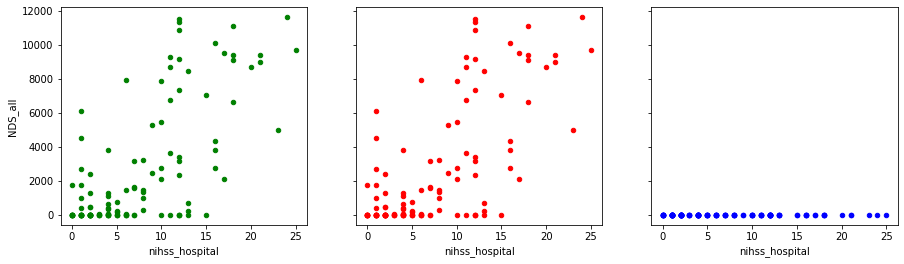

NDS-mean using all values: r and p-value = (0.16329035505497133, 0.07599448964540534)
NDS-mean using pos values: r and p-value = (0.4909813940377169, 1.4357317242911097e-08)
NDS-mean using neg values: r and p-value = (nan, nan)


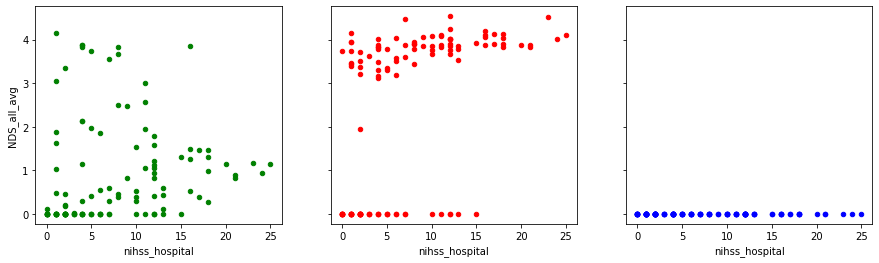

In [7]:
# Make plots and show r and p-values:

if LOOCV:
    display(clean_df[clean_df.str.startswith('NDS',na=True)])
    clean_df.to_csv(os.path.join(output_dir,'NDS_results.csv'), index=False)
else:
    print("NDS-sum using all values: r and p-value =",
          pearsonr(clean_df[VOI],clean_df['NDS_all']))
    print("NDS-sum using pos values: r and p-value =",
          pearsonr(clean_df[VOI],clean_df['NDS_pos']))
    print("NDS-sum using neg values: r and p-value =",
          pearsonr(clean_df[VOI],clean_df['NDS_neg']))

    fig, axs = plt.subplots(1,3,sharey=True,sharex=True)
    fig.set_size_inches(15,4)
    clean_df.plot(kind='scatter',x=VOI,y='NDS_all',color='green',ax=axs[0])
    clean_df.plot(kind='scatter',x=VOI,y='NDS_pos',color='red',ax=axs[1])
    clean_df.plot(kind='scatter',x=VOI,y='NDS_neg',color='blue',ax=axs[2])
    plt.show()
    
    print("NDS-mean using all values: r and p-value =",
          pearsonr(clean_df[VOI],clean_df['NDS_all_avg']))
    print("NDS-mean using pos values: r and p-value =",
          pearsonr(clean_df[VOI],clean_df['NDS_pos_avg']))
    print("NDS-mean using neg values: r and p-value =",
          pearsonr(clean_df[VOI],clean_df['NDS_neg_avg']))
    
    fig, axs = plt.subplots(1,3,sharey=True,sharex=True)
    fig.set_size_inches(15,4)
    clean_df.plot(kind='scatter',x=VOI,y='NDS_all_avg',color='green',ax=axs[0])
    clean_df.plot(kind='scatter',x=VOI,y='NDS_pos_avg',color='red',ax=axs[1])
    clean_df.plot(kind='scatter',x=VOI,y='NDS_neg_avg',color='blue',ax=axs[2])
    plt.show()
    clean_df.to_csv(os.path.join(output_dir,'NDS_results.csv'), index=False)

In [5]:
clean_df

,dataset,subject,lesion,nihss_hospital,Intercept,NDS_all,NDS_pos,NDS_neg,NDS_all_avg,NDS_pos_avg,NDS_neg_avg
0,corbetta_stroke,FCS_024,brain_lesions/FCS_024_A_lesion_ifhfix.nii,23,1,4982.656250,4982.656250,0.0,1.177098,4.513276,0.0
1,corbetta_stroke,FCS_026,brain_lesions/FCS_026_A_lesion_ifhfix.nii,2,1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,corbetta_stroke,FCS_027,brain_lesions/FCS_027_A_lesion_ifhfix.nii,20,1,8733.900391,8733.900391,0.0,1.153142,3.888647,0.0
3,corbetta_stroke,FCS_029,brain_lesions/FCS_029_A_lesion_ifhfix.nii,2,1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,corbetta_stroke,FCS_030,brain_lesions/FCS_030_A_lesion_ifhfix.nii,10,1,2132.420898,2132.420898,0.0,0.399929,3.774196,0.0
...,...,...,...,...,...,...,...,...,...,...,...
114,corbetta_stroke,FCS_181,brain_lesions/FCS_181_A_lesion_ifhfix.nii,12,1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
115,corbetta_stroke,FCS_182,brain_lesions/FCS_182_A_lesion_ifhfix.nii,3,1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
116,corbetta_stroke,FCS_183,brain_lesions/FCS_183_A_lesion_ifhfix.nii,2,1,13.614279,13.614279,0.0,0.009988,1.944897,0.0
117,corbetta_stroke,FCS_184,brain_lesions/FCS_184_A_lesion.nii,0,1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
